<a href="https://colab.research.google.com/github/MarkoMile/mlp-from-scratch/blob/master/MLP_minibatch_grad_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook i visualize representations a neural network creates in hidden layers.

I will use tools like pytorch

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [8]:
#DATA

def spiral_data():
    data = []
    labels = []
    n = 100

    # Generate first spiral
    for i in range(n):
        r = i/n * 5 + np.random.uniform(-0.1, 0.1)
        t = 1.25 * i/n * 2 * np.pi + np.random.uniform(-0.1, 0.1)
        data.append([r * np.sin(t), r * np.cos(t)])
        labels.append(1)

    # Generate second spiral
    for i in range(n):
        r = i/n * 5 + np.random.uniform(-0.1, 0.1)
        t = 1.25 * i/n * 2 * np.pi + np.pi + np.random.uniform(-0.1, 0.1)
        data.append([r * np.sin(t), r * np.cos(t)])
        labels.append(0)

    N = len(data)
    return data, labels

import numpy as np

def circle_data():
    data = []
    labels = []

    # Generate points for the first circle
    for i in range(50):
        r = np.random.uniform(0.0, 2.0)
        t = np.random.uniform(0.0, 2 * np.pi)
        data.append([r * np.sin(t), r * np.cos(t)])
        labels.append(1)

    # Generate points for the second circle
    for i in range(50):
        r = np.random.uniform(3.0, 5.0)
        t = 2 * np.pi * i / 50.0
        data.append([r * np.sin(t), r * np.cos(t)])
        labels.append(0)

    N = len(data)
    return data, labels



data, labels = circle_data()
# data, labels = spiral_data()


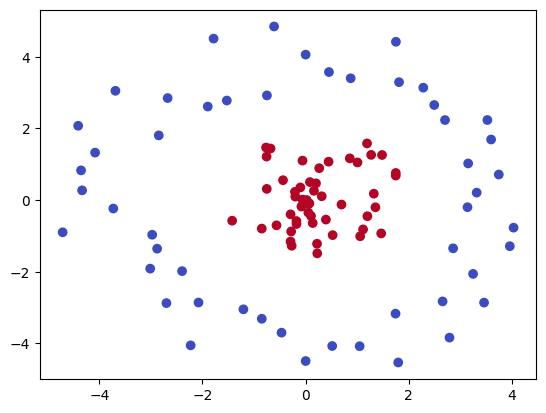

In [9]:
# create training and testing data from the data
data = np.array(data)
labels = np.array(labels)
N = len(data)
idx = np.arange(N)
np.random.shuffle(idx)
data = data[idx]
labels = labels[idx]

# Split data into training and testing
split = int(0.8 * N)
train_data = data[:split]
train_labels = labels[:split]
test_data = data[split:]
test_labels = labels[split:]

# Plot the spiral data
plt.scatter(data[:,0], data[:,1], c=labels, cmap='coolwarm')
plt.show()

In [12]:
# Convert data to PyTorch tensors
train_data = torch.FloatTensor(train_data)
train_labels = torch.LongTensor(train_labels)
test_data = torch.FloatTensor(test_data)
test_labels = torch.LongTensor(test_labels)

In [13]:
# Create a model
class Model(torch.nn.Module):
    x_before_output = None

    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(2, 3)
        self.fc2 = torch.nn.Linear(3, 3)
        self.fc3 = torch.nn.Linear(3, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
# Instantiate the model, the loss function, and the optimizer using basic functions
model = Model()
# Cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()
# SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
n_epochs = 1500
batch_size = 10
train_losses = []
test_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    permutation = torch.randperm(train_data.size()[0])

    for i in range(0, train_data.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = train_data[indices], train_labels[indices]

        optimizer.zero_grad()
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        permutation = torch.randperm(test_data.size()[0])
        for i in range(0, test_data.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = test_data[indices], test_labels[indices]

            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y)
            test_losses.append(loss.item())

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:27<00:00, 55.02it/s]


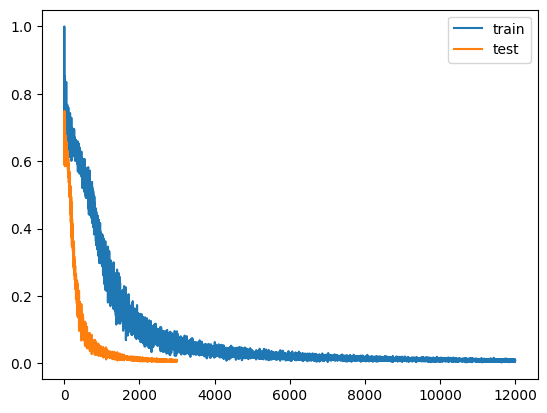

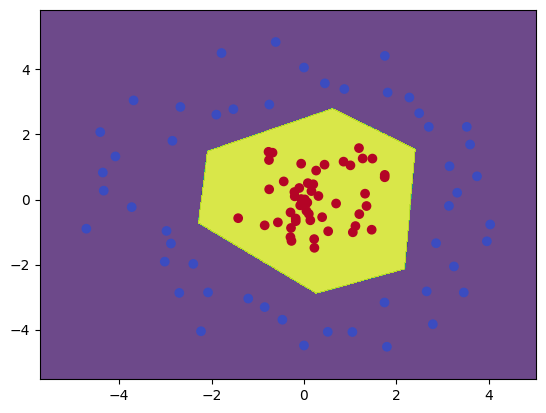

Accuracy: 1.00


In [15]:
# Plot the training and testing losses
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

# Plot the decision boundary
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.FloatTensor(grid)
model.eval()
pred = model(grid)
pred = torch.argmax(pred, dim=1).detach().numpy()
plt.contourf(xx, yy, pred.reshape(xx.shape), alpha=0.8)
plt.scatter(data[:,0], data[:,1], c=labels, cmap='coolwarm')
plt.show()

# Calculate the accuracy
model.eval()
y_pred = model(test_data)
y_pred = torch.argmax(y_pred, dim=1)
accuracy = (test_labels == y_pred).sum().item() / test_labels.size(0)
print(f'Accuracy: {accuracy:.2f}')

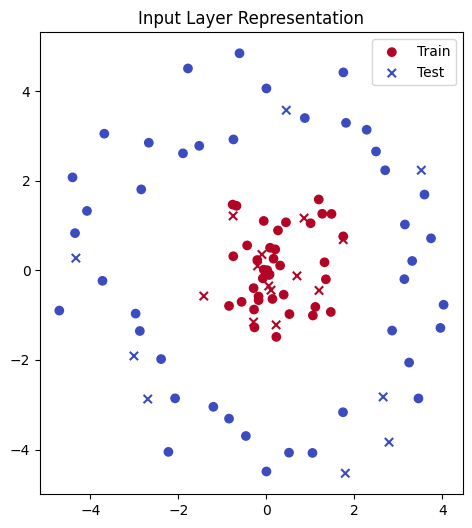

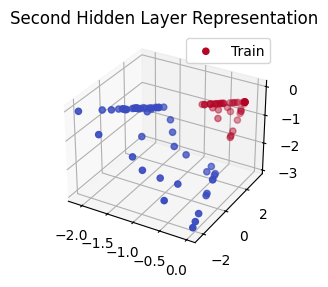

In [20]:
# Extract input layer representation (train + test)
input_layer_train = train_data
input_layer_test = test_data

# data after each layer
x = torch.FloatTensor(data)
first_layer = model.fc1(x)
first_layer_relu = torch.relu(first_layer)
second_layer = model.fc2(first_layer_relu)
second_layer_relu = torch.relu(second_layer)
output_layer = model.fc3(second_layer_relu)


# Plot input layer representation (train + test)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(input_layer_train[:, 0].detach().numpy(), input_layer_train[:, 1].detach().numpy(), c=train_labels, cmap='coolwarm', label='Train')
plt.scatter(input_layer_test[:, 0].detach().numpy(), input_layer_test[:, 1].detach().numpy(), c=test_labels, cmap='coolwarm', marker='x', label='Test')
plt.title('Input Layer Representation')
plt.legend()
plt.show()

# Plot second hidden layer representation (train + test) [3d]
ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter(second_layer[:, 0].detach().numpy(), second_layer[:, 1].detach().numpy(), second_layer[:, 2].detach().numpy(), c=labels, cmap='coolwarm', label='Train')
plt.title('Second Hidden Layer Representation')
plt.legend()
plt.show()



